In [1]:
import os
os.getcwd()


'/workspace/ab-testing-simulation/notebooks'

## Data & Group Overview

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
import scipy.stats as stats
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

In [3]:
# Loading and examining the dataset
df = pd.read_csv('/workspace/ab-testing-simulation/data/ab_test_data.csv')
df.head()

,user_id,group,converted,session_duration,pages_viewed,device_type,revenue
0,1,A,0,125,3,mobile,0.00
1,2,A,1,79,2,desktop,41.13
2,3,A,0,131,1,mobile,0.00
3,4,A,0,138,1,tablet,0.00
4,5,A,0,136,1,desktop,0.00


In [4]:
# Checking for missing values and viewing summary statistics

df.info()
df.describe().transpose().round(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           2000 non-null   int64  
 1   group             2000 non-null   object 
 2   converted         2000 non-null   int64  
 3   session_duration  2000 non-null   int64  
 4   pages_viewed      2000 non-null   int64  
 5   device_type       2000 non-null   object 
 6   revenue           2000 non-null   float64
dtypes: float64(1), int64(4), object(2)
memory usage: 109.5+ KB


,count,mean,std,min,25%,50%,75%,max
user_id,2000.0,1000.50,577.49,1.0,500.75,1000.5,1500.25,2000.00
converted,2000.0,0.13,0.33,0.0,0.00,0.0,0.00,1.00
session_duration,2000.0,128.72,31.14,19.0,108.00,128.0,150.00,236.00
pages_viewed,2000.0,3.47,1.86,1.0,2.00,3.0,5.00,13.00
revenue,2000.0,4.35,11.99,0.0,0.00,0.0,0.00,59.92


In [5]:
# Checking user distribution among test groups
df['group'].value_counts()

group
A    1000
B    1000
Name: count, dtype: int64

In [6]:
# Descriptive Statistics / Performance Metrics overview by group

group_summary = df.groupby('group').agg({
    'user_id': 'count',
    'revenue': ['mean', 'median', 'std'],
    'session_duration': ['mean', 'median', 'std']
})

group_summary.columns = ['_'.join(col) for col in group_summary.columns]
group_summary.reset_index(inplace=True)
group_summary.round(2)


,group,user_id_count,revenue_mean,revenue_median,revenue_std,session_duration_mean,session_duration_median,session_duration_std
0,A,1000,4.25,0.0,11.90,122.46,122.0,29.67
1,B,1000,4.45,0.0,12.08,134.98,134.0,31.33


## Revenue & Session Duration: Normality Test & Evaluation Method Selection

In [16]:
# Splitting the test groups into seperate df
group_a = df[df['group'] == 'A']
group_b = df[df['group'] == 'B']

In [17]:
# Testing for normality of distribution using Shapiro-Wilk test

print("Shapiro-Wilk Normality Test for Revenue:")
stat_a, p_a = shapiro(group_a['revenue'])
stat_b, p_b = shapiro(group_b['revenue'])
print(f"Group A: W={stat_a:.4f}, p={p_a:.4f}")
print(f"Group B: W={stat_b:.4f}, p={p_b:.4f}")

print("\nShapiro-Wilk Normality Test for Session Duration:")
stat_a, p_a = shapiro(group_a['session_duration'])
stat_b, p_b = shapiro(group_b['session_duration'])
print(f"Group A: W={stat_a:.4f}, p={p_a:.4f}")
print(f"Group B: W={stat_b:.4f}, p={p_b:.4f}")


Shapiro-Wilk Normality Test for Revenue:
Group A: W=0.4014, p=0.0000
Group B: W=0.4095, p=0.0000

Shapiro-Wilk Normality Test for Session Duration:
Group A: W=0.9985, p=0.5442
Group B: W=0.9976, p=0.1649


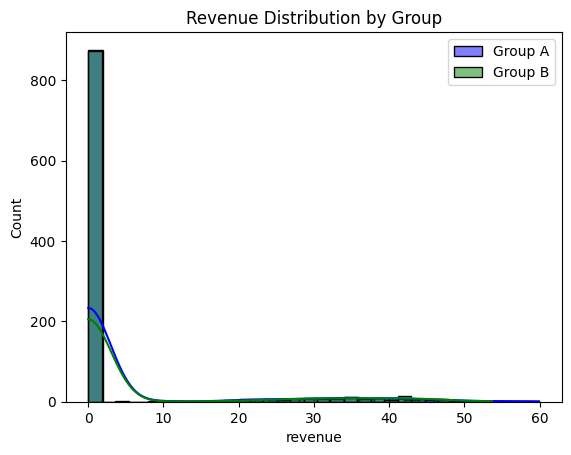

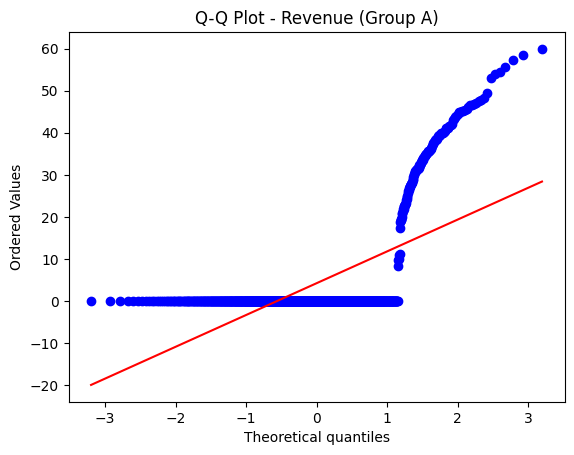

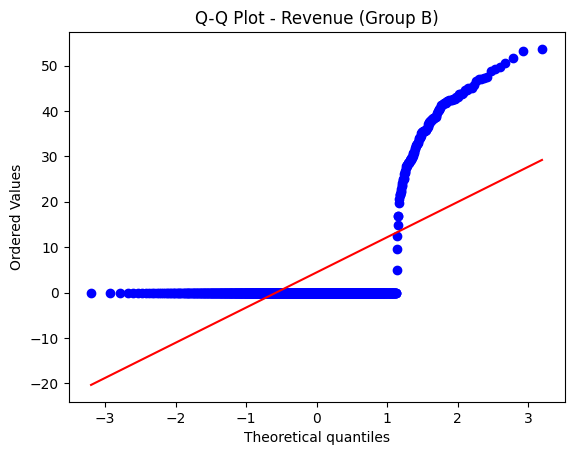

In [10]:
# Histogram
sns.histplot(group_a['revenue'], kde=True, color='blue', label='Group A', bins=30)
sns.histplot(group_b['revenue'], kde=True, color='green', label='Group B', bins=30)
plt.title("Revenue Distribution by Group")
plt.legend()
plt.show()

# Q-Q Plot
stats.probplot(group_a['revenue'], dist="norm", plot=plt)
plt.title("Q-Q Plot - Revenue (Group A)")
plt.show()

stats.probplot(group_b['revenue'], dist="norm", plot=plt)
plt.title("Q-Q Plot - Revenue (Group B)")
plt.show()


## Hypothesis Testing: Revenue (Mann-Whitney U Test)

In [11]:
# Split Revenue data for each group
group_a_revenue = df[df['group'] == 'A']['revenue']
group_b_revenue = df[df['group'] == 'B']['revenue']

# Perform Mann-Whitney U Test
u_stat, p_value = mannwhitneyu(group_a_revenue, group_b_revenue, alternative='two-sided')

print("Mann-Whitney U Test Results")
print(f"U-statistic: {u_stat:.2f}")
print(f"P-value: {p_value:.4f}")


Mann-Whitney U Test Results
U-statistic: 497679.00
P-value: 0.7553


## Hypothesis Testing: Session Duration (T-Test)

In [12]:
# Performing a two-sided (independent) t-test
t_stat, p_val = ttest_ind(
    df[df['group'] == 'A']['session_duration'],
    df[df['group'] == 'B']['session_duration'],
    equal_var=False  # Welch's t-test (recommended when variances might differ)
)

print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_val:.4f}")


T-statistic: -9.17
P-value: 0.0000


## Pages Viewed: Normality Test & Evaluation Method Selection

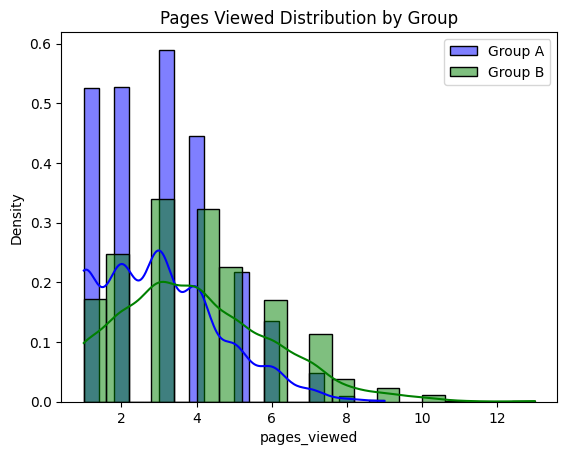

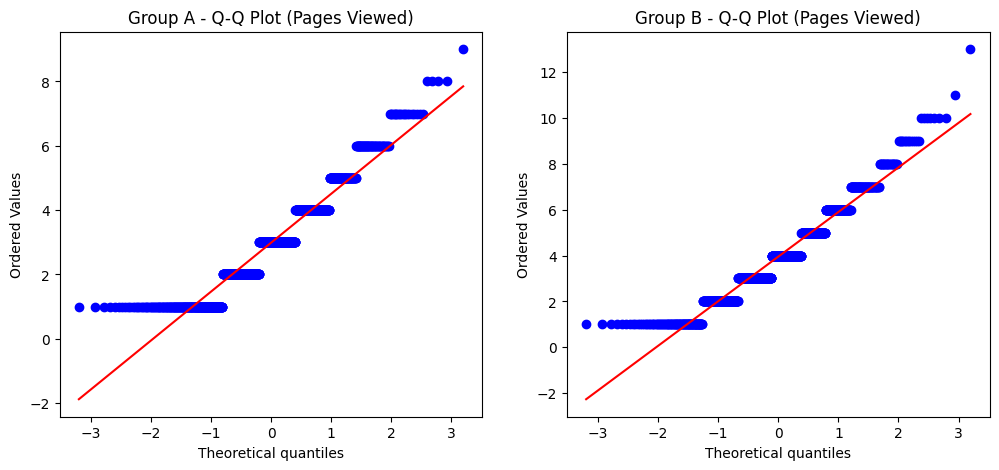

In [19]:
# Plotting the histograms for both groups
sns.histplot(df[df['group'] == 'A']['pages_viewed'], kde=True, color='blue', label='Group A', stat='density')
sns.histplot(df[df['group'] == 'B']['pages_viewed'], kde=True, color='green', label='Group B', stat='density')
plt.legend()
plt.title('Pages Viewed Distribution by Group')
plt.show()

# Plotting the Q-Q Plots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
stats.probplot(df[df['group'] == 'A']['pages_viewed'], dist="norm", plot=ax[0])
ax[0].set_title('Group A - Q-Q Plot (Pages Viewed)')
stats.probplot(df[df['group'] == 'B']['pages_viewed'], dist="norm", plot=ax[1])
ax[1].set_title('Group B - Q-Q Plot (Pages Viewed)')
plt.show()

In [18]:
# Testing for normality of distribution using Shapiro-Wilk test

a_stat, a_p = stats.shapiro(df[df['group'] == 'A']['pages_viewed'])
b_stat, b_p = stats.shapiro(df[df['group'] == 'B']['pages_viewed'])

print("Shapiro-Wilk Normality Test for Pages viewed:")
print(f"Group A: W={a_stat:.4f}, p={a_p:.4f}")
print(f"Group B: W={b_stat:.4f}, p={b_p:.4f}")


Shapiro-Wilk Normality Test for Pages viewed:
Group A: W=0.9175, p=0.0000
Group B: W=0.9459, p=0.0000


In [20]:
# Split pages_viewed data for each group
group_a_pages = df[df['group'] == 'A']['pages_viewed']
group_b_pages = df[df['group'] == 'B']['pages_viewed']

# Perform Mann-Whitney U Test
u_stat, p_value = mannwhitneyu(group_a_pages, group_b_pages, alternative='two-sided')

# Print results
print("Mann-Whitney U Test Results (Pages Viewed)")
print(f"U-statistic: {u_stat:.2f}")
print(f"P-value: {p_value:.4f}")


Mann-Whitney U Test Results (Pages Viewed)
U-statistic: 359477.50
P-value: 0.0000


The p-value is far below 0.05, accordingly we reject the null hypothesis. This means the difference in pages viewed between Group A and Group B is statistically significant.

Based on the examined distribution plots, Group B users tend to view more pages than Group A, indicating higher engagement.